# `DRAP`: Database of Remote Affective Physiological Signals and Continuous Ratings Collected in Virtual Reality

Notebook containing the postprocessing stages for the DRAP dataset.

It transforms individual files containing events (.json) and physiological responses (.csv) per each participant, and produces a single file `Dataset_DRAP_full_postprocessed.csv` synchronizing: 

1) Amplitude from Physiological responses. 
2) Affect ratings.
3) Start and End of intervention stages Resting and Video for three types of video content: 
    - VideoNegative
    - VideoPositive
    - VideoNeutral

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Import classes
import drap
import utils  # Utils for generation of files and paths

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
#%matplotlib inline
import seaborn as sns

# Statistical tests
import scipy.stats as stats
from scipy.stats import mannwhitneyu

# Preprocessing
import neurokit2 as nk      # Imported locally from dev branch

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Feature based classification

from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lime import lime_tabular

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

File Path: e:\dsv\dev\git_repos\xai-in-affect-detection/


---
# SETUP

In [2]:
# CONSTANTS
import experiment_config

# All the files generated from this notebook are in a subfolder with this name
NOTEBOOK_SUBFOLDER_NAME = '1_FeatureBasedXAI/'

# Setup of overlapping windows to extract features from time series
SAMPLING_PERIOD_TS = 1 # seconds

#### Classification methods to apply.
DICT_CLASSIFIERS = {
    "KNN":    KNeighborsClassifier(n_neighbors=experiment_config.KNN_N_NEIGH),
    "DT":     DecisionTreeClassifier(max_depth=experiment_config.DT_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    "RF":     RandomForestClassifier(n_estimators=experiment_config.RF_N_ESTIMATORS, max_depth=experiment_config.RF_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    "GBM":    GradientBoostingClassifier(n_estimators=experiment_config.GBM_N_ESTIMATORS, max_depth=experiment_config.GBM_MAX_DEPTH, criterion='friedman_mse', random_state=experiment_config.MC_RANDOM_SEED)
}

## K-Fold partition
N_SPLITS_CV = experiment_config.CV_NUM_FOLDS # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

## UTILITY FUNCTIONS

Generate paths to write output files

In [3]:
STR_DATASET = str(experiment_config.DATASET_MAIN)+"/"
print(STR_DATASET)
def gen_path_plot(filename, extension=None):
    # Generates full paths for PLOTS just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.PLOT_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME, \
                                        file_extension=experiment_config.IMG_FORMAT if extension is None else extension, \
                                        save_files=experiment_config.EXPORT_PLOTS)

def gen_path_temp(filename, subfolders="", extension=experiment_config.TEMP_FORMAT):
    # Generates full paths for TEMP FILES just by specifying a name
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.TEMP_FOLDER, \
                                        subfolders=STR_DATASET+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return utils.generate_complete_path(filename, \
                                        main_folder=experiment_config.RESULTS_FOLDER, \
                                        subfolders=STR_DATASET+NOTEBOOK_SUBFOLDER_NAME+subfolders, \
                                        file_extension=extension)

DRAP/


## DATASETS: Loading and EDA plots


In [4]:
print("\t>>>LOADING DATASETS")
dataset = None
classes = None

	>>>LOADING DATASETS


In [5]:
DATASET_POSTPROCESSED_FILENAME = gen_path_temp("Dataset_DRAP_full_postprocessed", extension=".csv")
print(DATASET_POSTPROCESSED_FILENAME)
dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)
dataset.head()

./temp/DRAP/Dataset_DRAP_full_postprocessed.csv


,Participant,Stage,Time,OriginalParticipantID,HeartRate/Average,Ppg/Raw.ppg,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightFrontalis],...,Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],VideoId,Valence,Arousal,RawX,RawY
0,0,VideoNegative,0.00,101,76.39,31120,850,49,-457,29,...,74,38,54,44,31,18,4.0,6.0,127.0,141.0
1,0,VideoNegative,0.02,101,76.39,31120,849,49,-456,31,...,86,38,48,44,36,18,4.0,6.0,127.0,141.0
2,0,VideoNegative,0.04,101,76.39,31120,857,48,-453,30,...,91,38,47,48,37,18,4.0,6.0,127.0,141.0
3,0,VideoNegative,0.06,101,76.39,27888,848,49,-453,30,...,92,39,43,47,40,18,4.0,6.0,127.0,141.0
4,0,VideoNegative,0.08,101,76.39,27888,855,45,-453,29,...,78,41,42,53,40,18,4.0,6.0,127.0,141.0


In [6]:
dataset = dataset.set_index(["Time"])
dataset.head()

,Participant,Stage,OriginalParticipantID,HeartRate/Average,Ppg/Raw.ppg,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],VideoId,Valence,Arousal,RawX,RawY
Time,,,,,,,,,,,,,,,,,,,,
0.00,0,VideoNegative,101,76.39,31120,850,49,-457,29,27,74,38,54,44,31,18,4.0,6.0,127.0,141.0
0.02,0,VideoNegative,101,76.39,31120,849,49,-456,31,28,86,38,48,44,36,18,4.0,6.0,127.0,141.0
0.04,0,VideoNegative,101,76.39,31120,857,48,-453,30,30,91,38,47,48,37,18,4.0,6.0,127.0,141.0
0.06,0,VideoNegative,101,76.39,27888,848,49,-453,30,32,92,39,43,47,40,18,4.0,6.0,127.0,141.0
0.08,0,VideoNegative,101,76.39,27888,855,45,-453,29,35,78,41,42,53,40,18,4.0,6.0,127.0,141.0


### General variables to access dataset

In [7]:
participants_ids = dataset["Participant"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int64)

In [8]:
experiment_segment_names = dataset["Stage"].unique()
experiment_segment_names

array(['VideoNegative', 'Resting_VideoNegative', 'VideoPositive',
       'Resting_VideoPositive', 'VideoNeutral', 'Resting_VideoNeutral'],
      dtype=object)

In [9]:
video_ids = dataset["VideoId"].unique()
print(np.sort(video_ids))
# NaN (or -1) refers to the resting stages, no video is presented.

[-1  3  4  5  6 10 12 13 18 19 20 21 22 23 25 29 31 33 37 38 39 41 42 46
 48 49 51 55 56 57 58]


In [10]:
# Delete rows that have invalid VideoId. Meaning, -1 although they belong to experimental session
Q = (( dataset["VideoId"]==-1) & ~(dataset["Stage"].str.startswith("Resting_")))
dataset[Q]
# Should be empty.

,Participant,Stage,OriginalParticipantID,HeartRate/Average,Ppg/Raw.ppg,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightFrontalis],Emg/Amplitude[RightZygomaticus],Emg/Amplitude[RightOrbicularis],Emg/Amplitude[CenterCorrugator],Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],VideoId,Valence,Arousal,RawX,RawY
Time,,,,,,,,,,,,,,,,,,,,


In [11]:
# Check which videoIds belong to each Experimental Stage
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])

    Q = ( dataset["Stage"] == segment )
    
    # Keep unique video ids
    video_ids_per_segment[segment] = dataset[Q]["VideoId"].unique()
    
video_ids_per_segment

{'VideoNegative': array([18, 10,  5, 13, 12, 19,  3,  4, 20,  6], dtype=int64),
 'Resting_VideoNegative': array([-1], dtype=int64),
 'VideoPositive': array([51, 49, 46, 41, 48, 57, 56, 58, 42, 55], dtype=int64),
 'Resting_VideoPositive': array([-1], dtype=int64),
 'VideoNeutral': array([25, 38, 29, 37, 31, 33, 22, 39, 23, 21], dtype=int64),
 'Resting_VideoNeutral': array([-1], dtype=int64)}

In [12]:
# Used to define the segments of interest and the mapping for classifiers
CLASSES_MAPPING = {
            "VideoNegative": -1,
            "VideoNeutral": 0,
            "VideoPositive": 1,
            }
            
CLASSES_MAPPING_INVERSE = { v:k for k,v in CLASSES_MAPPING.items()}

# Used to plot proper names of the experimental stages
EXP_STAGE_NAME_MAPPING = {
            "VideoNegative": "Negative",
            "VideoNeutral": "Neutral",
            "VideoPositive": "Positive",
}

In [13]:
# Redefining the index
dataset = dataset.reset_index().set_index(["Participant","Stage","Time"])
dataset.head()

OriginalParticipantID  HeartRate/Average  \
Participant Stage         Time                                             
0           VideoNegative 0.00                    101              76.39   
                          0.02                    101              76.39   
                          0.04                    101              76.39   
                          0.06                    101              76.39   
                          0.08                    101              76.39   

                                Ppg/Raw.ppg  Accelerometer/Raw.x  \
Participant Stage         Time                                     
0           VideoNegative 0.00        31120                  850   
                          0.02        31120                  849   
                          0.04        31120                  857   
                          0.06        27888                  848   
                          0.08        27888                  855   

                                Accelerometer/Raw.y  Accelerometer/Raw.z  \
Participant Stage         Time                                             
0           VideoNegative 0.00                   49                 -457   
                          0.02                   49                 -456   
                          0.04                   48                 -453   
                          0.06                   49                 -453   
                          0.08                   45                 -453   

                                Emg/Amplitude[RightFrontalis]  \
Participant Stage         Time                                  
0           VideoNegative 0.00                             29   
                          0.02                             31   
                          0.04                             30   
                          0.06                             30   
                          0.08                             29   

                                Emg/Amplitude[RightZygomaticus]  \
Participant Stage         Time                                    
0           VideoNegative 0.00                               27   
                          0.02                               28   
                          0.04                               30   
                          0.06                               32   
                          0.08                               35   

                                Emg/Amplitude[RightOrbicularis]  \
Participant Stage         Time                                    
0           VideoNegative 0.00                               74   
                          0.02                               86   
                          0.04                               91   
                          0.06                               92   
                          0.08                               78   

                                Emg/Amplitude[CenterCorrugator]  \
Participant Stage         Time                                    
0           VideoNegative 0.00                               38   
                          0.02                               38   
                          0.04                               38   
                          0.06                               39   
                          0.08                               41   

                                Emg/Amplitude[LeftOrbicularis]  \
Participant Stage         Time                                   
0           VideoNegative 0.00                              54   
                          0.02                              48   
                          0.04                              47   
                          0.06                              43   
                          0.08                              42   

                                Emg/Amplitude[LeftZygomaticus]  \
Participant Stage         Time                                   
0           VideoNegative 0.

## Exploratory Data Analysis

In [14]:
participant = 0
segment = "VideoNegative"
video_id = video_ids_per_segment[segment][0] # Access the dictionary of videos existing in the segment, choose the first VideoId

# Select a whole experimental segment
single_segment_ts = dataset.loc[(participant,segment)]
# Select a specific video inside the experimental segment
single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == video_id]

e:\dsv\dev\git_repos\xai-in-affect-detection\env\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

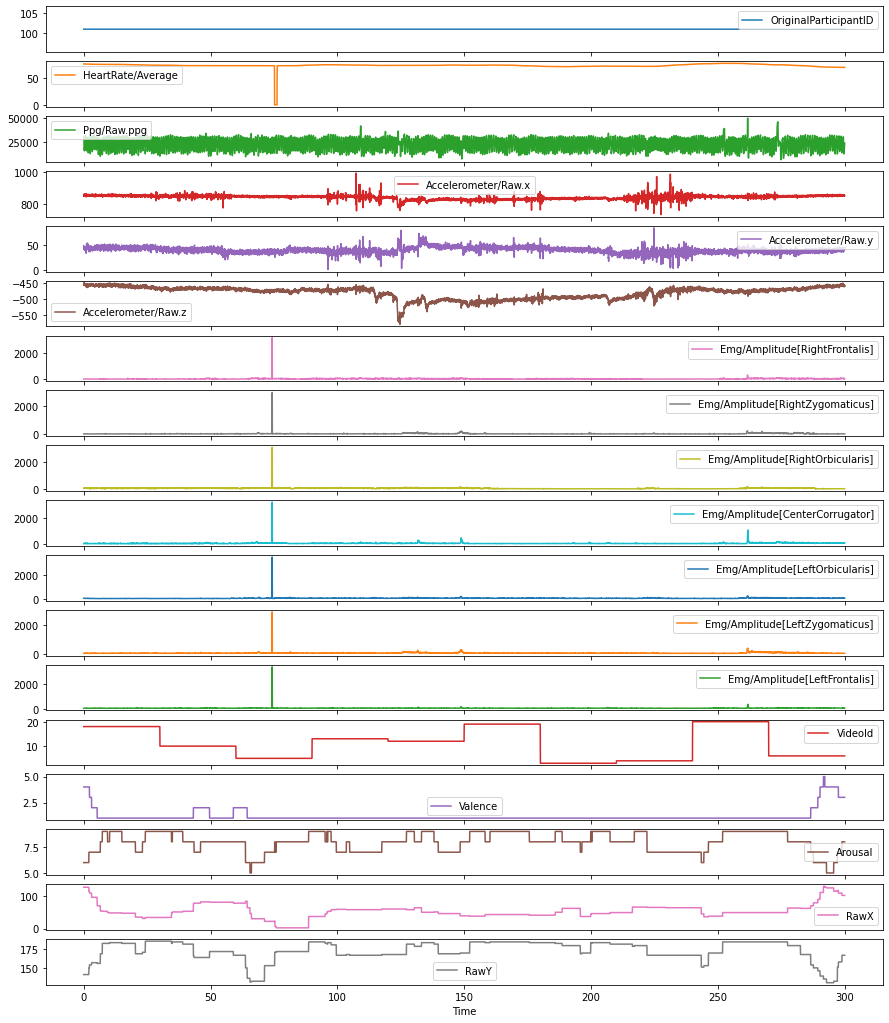

In [15]:
single_segment_ts.plot.line(subplots=True, figsize=(15,1*single_segment_ts.shape[1]), sharex=True)

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

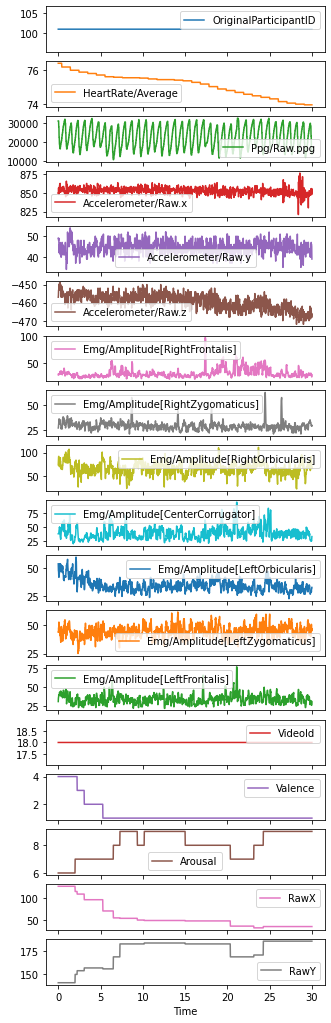

In [16]:
single_video_ts.plot.line(subplots=True, figsize=(5,1*single_video_ts.shape[1]), sharex=True)

---

# A) Statistical Analysis of Subjective Self-Reported Interval Data

Validate whether the average self-reported **valence** measures differ between video categories aiming to induce `Negative`, `Neutral`, and `Positive` emotions.

**Method:** Paired t-test to compare the mean of two samples.

## Summary of reported V-A values

Generate a table with the summary of self-reported V-A values per videoId and per participant

In [19]:
#### Extract the valence and arousal per video
    
# Where the compiled dataset will be stored
DATA_OUTPUT_FILENAME = gen_path_results("1_AverageSelfReportedAffect", extension=".csv")

# Load or create dataframe with statistics of initial dataset
df_results = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [DATA_OUTPUT_FILENAME]

# Try to load files maximum two times
RELOAD_TRIES = 2
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        for segment in experiment_segment_names:
            # Only valid experimental sessions (no resting)
            if segment in list(CLASSES_MAPPING.keys()): 
                # Iterate all videos from the segment
                for video_id in video_ids_per_segment[segment]:
                    
                    # Load and average the data from each participant per video
                    for participant in participants_ids:
                        single_segment_ts = dataset.loc[(participant,segment)]
                        single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == video_id]

                        dict_this_result = {
                                        "VideoId":      [video_id],
                                        "participant":  [participant],
                                        "originalParticipantID": [single_video_ts.OriginalParticipantID.unique()],
                                        "segment":      [segment],
                                        "sum_Valence":  [single_video_ts.Valence.values.sum()],
                                        "sum_RawX":     [single_video_ts.RawX.values.sum()],
                                        "sum_Arousal":  [single_video_ts.Arousal.values.sum()],
                                        "sum_RawY":     [single_video_ts.RawY.values.sum()],
                                        "std_Valence":  [single_video_ts.Valence.values.std()],
                                        "std_RawX":     [single_video_ts.RawX.values.std()],
                                        "std_Arousal":  [single_video_ts.Arousal.values.std()],
                                        "std_RawY":     [single_video_ts.RawY.values.std()],
                                        "N":            [single_video_ts.Valence.values.size],
                                        }
                
                        df_this_result = pd.DataFrame(dict_this_result)
                        # Append to the main dataframe with the results 
                        df_results = df_this_result if (df_results is None) else pd.concat([df_results, df_this_result])

        # Save data
        print(df_results.head())

        # Saving .csv
        df_results.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise

    # Finish iteration
    break

Trying 1/2 to load files: ['./results/DRAP/1_FeatureBasedXAI/1_AverageSelfReportedAffect.csv']
File not found. Creating again! [Errno 2] No such file or directory: './results/DRAP/1_FeatureBasedXAI/1_AverageSelfReportedAffect.csv'


e:\dsv\dev\git_repos\xai-in-affect-detection\env\lib\site-packages\ipykernel_launcher.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
e:\dsv\dev\git_repos\xai-in-affect-detection\env\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
e:\dsv\dev\git_repos\xai-in-affect-detection\env\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
e:\dsv\dev\git_repos\xai-in-affect-detection\env\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   VideoId  participant originalParticipantID        segment  sum_Valence  \
0       18            0                 [101]  VideoNegative       2031.0   
0       18            1                 [216]  VideoNegative       1738.0   
0       18            2                 [219]  VideoNegative      10057.0   
0       18            3                 [222]  VideoNegative       2969.0   
0       18            4                 [246]  VideoNegative       2819.0   

   sum_RawX  sum_Arousal  sum_RawY  std_Valence   std_RawX  std_Arousal  \
0   83690.0      12076.0  262277.0     0.855619  27.411182     0.964016   
0   60721.0       7291.0  182901.0     0.678899  22.832579     0.980203   
0  248983.0      11875.0  260448.0     2.718541  49.749182     0.991374   
0  128356.0      10800.0  246089.0     1.460626  23.502321     0.407953   
0  116780.0       6086.0  154313.0     1.284046  25.276494     1.415879   

    std_RawY     N  
0  13.842082  1501  
0  16.807640  1499  
0  15.348339  1501  
0 

In [20]:
# Calculate the summary of self-reported VA ratings grouped per video
df_affect_per_videoId = df_results.copy()
df_affect_per_videoId = df_affect_per_videoId.groupby("VideoId").sum()
df_affect_per_videoId = df_affect_per_videoId.join(df_results.groupby("VideoId").first().segment)
df_affect_per_videoId.index = df_affect_per_videoId.index.astype(int)
df_affect_per_videoId.head()

,participant,sum_Valence,sum_RawX,sum_Arousal,sum_RawY,std_Valence,std_RawX,std_Arousal,std_RawY,N,segment
VideoId,,,,,,,,,,,
3,820,149475.0,5307319.0,406323.0,9203071.0,48.750317,914.507088,52.881826,961.741286,58509,VideoNegative
4,820,135112.0,4935792.0,410672.0,9353021.0,28.877155,592.442571,43.340877,728.554034,58503,VideoNegative
5,820,194649.0,6093094.0,329194.0,7821907.0,62.662524,1229.680773,52.260081,977.757832,60018,VideoNegative
6,820,191349.0,5988669.0,336560.0,7976173.0,44.719137,897.687943,48.976430,859.736281,58513,VideoNegative
10,820,170514.0,5792428.0,409395.0,9345773.0,55.149862,1001.154158,49.630876,898.003499,59789,VideoNegative


## Plot reported V-A values per video across all data from participants

*Conclusion from plot:*
- It shows how the video categories: `VideoNegative` and `VideoPositive` can be discriminated from the Valence component. 
- These two groups may be used as ground-truth for the ML task, **excluding** `VideoNeutral`

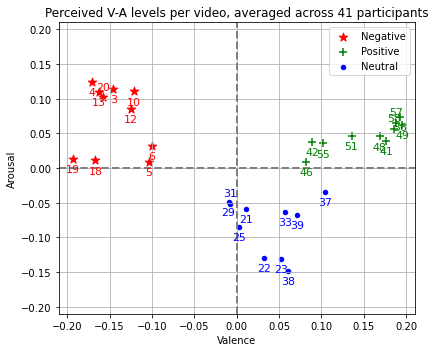

In [71]:
# Plotting how each video was rated among all self-reported datapoints across all 15 participants.
save_path_plot = gen_path_results("1_AffectPerVideoId", extension=".pdf")

fig = plt.figure(figsize=(6, 5))

lim = 0.21
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title(f"Perceived V-A levels per video, averaged across {participants_ids.size} participants")

plt.vlines([0], ymin=-lim, ymax=lim, color="gray", linestyle='dashed', linewidth=2)
plt.hlines([0], xmin=-lim, xmax=lim, color="gray", linestyle='dashed', linewidth=2)

kwargs = {"VideoNegative":{
                    "c":"red", "marker":"*"
                    },
            "VideoPositive":{
                    "c":"green", "marker":"+"
                },
            "VideoNeutral":{
                    "c":"blue", "marker":"."
                }
            }

for segment in experiment_segment_names:
    if segment in list(CLASSES_MAPPING.keys()):
        df_test = df_affect_per_videoId[ (df_affect_per_videoId.segment == segment)]
        avg_V = ((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = ((df_test.sum_RawY/df_test.N)-128)/256

        plt.scatter( avg_V, avg_A, label=EXP_STAGE_NAME_MAPPING[segment], s=80, **kwargs[segment] ) #c=colors[segment], s=80, marker=markers[segment])

        for i, videoId in enumerate(df_test.index.values):
            # Defines where to offset the annotations depending on how many neighbors are there
            offsetX = 0.00
            offsetY = 0.015

            offset_dict = {
                0: [0, -offsetY],
                1: [0, offsetY],
                2: [offsetX, 0],
                3: [-offsetX, 0]
            }
            # Define offset based on how many points are close to the value
            thresh = 0.01
            radius = np.sqrt(np.abs(avg_A.iloc[i] - avg_A.iloc[:i])**2 + (np.abs(avg_V.iloc[i] - avg_V.iloc[:i])**2))
            n_close_neighbors = (radius<thresh).sum()
            offset_annotation = offset_dict[n_close_neighbors]

            # Annotate
            plt.annotate(videoId, (avg_V.iloc[i]+offset_annotation[0], avg_A.iloc[i]+offset_annotation[1]), 
                            fontsize=11, 
                            ha='center', va='center',
                            color=kwargs[segment]["c"])

plt.grid(True)
plt.legend()
fig.tight_layout()

plt.show()
fig.savefig(save_path_plot)

## Plot reported V-A values per participant  across video category

*Conclusion from plot:*
- It shows how the video categories: `VideoNegative` and `VideoPositive` can be discriminated from the Valence component. 
- These two groups may be used as ground-truth for the ML task, **excluding** `VideoNeutral`

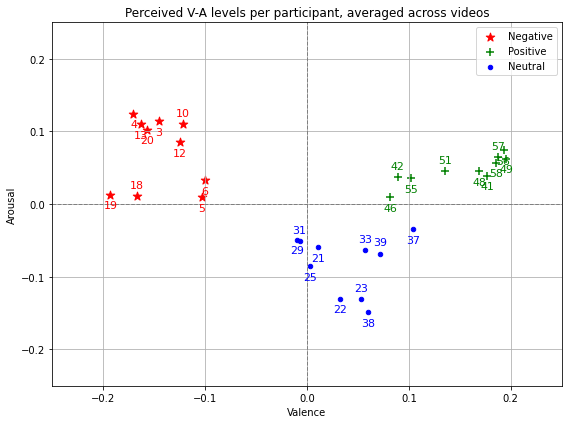

In [59]:
# Plotting how each participant rated the category of videos
save_path_plot = gen_path_results("2_AffectPerParticipant", extension=".pdf")

fig = plt.figure(figsize=(8, 6))

lim = 0.25
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title(f"Perceived V-A levels per participant, averaged across videos")

plt.vlines([0], ymin=-lim, ymax=lim, color="gray", linestyle='dashed', linewidth=0.99)
plt.hlines([0], xmin=-lim, xmax=lim, color="gray", linestyle='dashed', linewidth=0.99)

kwargs = {"VideoNegative":{
                    "c":"red", "marker":"*"
                    },
            "VideoPositive":{
                    "c":"green", "marker":"+"
                },
            "VideoNeutral":{
                    "c":"blue", "marker":"."
                }
            }

for segment in experiment_segment_names:
    if segment in list(CLASSES_MAPPING.keys()):
        df_test = df_affect_per_videoId[ (df_affect_per_videoId.segment == segment)]
        avg_V = ((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = ((df_test.sum_RawY/df_test.N)-128)/256

        plt.scatter( avg_V, avg_A, label=EXP_STAGE_NAME_MAPPING[segment], s=80, **kwargs[segment] ) #c=colors[segment], s=80, marker=markers[segment])

        for i, videoId in enumerate(df_test.index.values):
            # Defines where to offset the annotations depending on how many neighbors are there
            offsetX = 0
            offsetY = -0.015

            offset_dict = {
                0: [offsetX,offsetY],
                1: [offsetX, -offsetY],
                2: [-offsetX, offsetY],
                3: [-offsetX, -offsetY]
            }

            n_close_neighbors = (np.abs(avg_A.iloc[i] - avg_A.iloc[:i])<0.005).sum()
            offset_annotation = offset_dict[n_close_neighbors]
            plt.annotate(videoId, (avg_V.iloc[i]+offset_annotation[0], avg_A.iloc[i]+offset_annotation[1]), 
                            fontsize=11, 
                            ha='center', va='center',
                            color=kwargs[segment]["c"])

plt.grid(True)
plt.legend()
fig.tight_layout()

plt.show()
fig.savefig(save_path_plot)

## Plot reported V-A values for `VideoPositive` and `VideoNegative`

*Conclusion from plot:*
- Difficult to understand
- **Do not include in report!!**

In [ ]:
# Scatter plot per segment, one data point represents an average self-reported affect assessment for a video of 30-sec long
# CONCLUSION: Difficult to interpret, perhaps not worth analyzing it.

# save_path_plot = gen_path_results("1_PerceivedAffectVideosPositiveNegative", extension=".pdf")
df_affect_per_segment = df_results.copy()

fig = plt.figure(figsize=(6, 4))

lim = 0.28
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title("Average of all Valence-Arousal values among videos and participants")
plt.vlines([0], ymin=-lim, ymax=lim, color="gray", linestyle='dashed', linewidth=0.99)
plt.hlines([0], xmin=-lim, xmax=lim, color="gray", linestyle='dashed', linewidth=0.99)

for segment in experiment_segment_names:
    if segment in ["VideoNegative","VideoPositive"]:
        df_test = df_affect_per_segment[ (df_affect_per_segment.segment == segment)]
        avg_V = ((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = ((df_test.sum_RawY/df_test.N)-128)/256
        plt.scatter( avg_V, avg_A, label=EXP_STAGE_NAME_MAPPING[segment], s=20, c=colors[segment])

plt.legend()
fig.tight_layout()
plt.show()

# Save
# fig.savefig(save_path_plot)

## Plot average change in reported Valence values compared to `VideoNeutral`

*Conclusion from plot and Mann-Whitney tests:*
- Average reported valence is *higher* for videos inducing *positive* affect
- Average reported valence is *lower* for videos inducing *negative* affect

In [ ]:
# Show how each participant rated the positive and negative videos w.r.t. the average values of the Neutral videos.

# Calculate average values assigned per participant during Neutral Videos
df_affective_per_participant = df_results[df_results.segment=="VideoNeutral"].groupby("participant").sum()
df_avg_neutral_valence_per_participant = ((df_affective_per_participant.sum_RawX/df_affective_per_participant.N)-128)/256
df_avg_neutral_valence_per_participant
df_affective_per_participant = df_results.copy()

# Replace the value on the average ratings fro Non-Neutral videos
df = df_affective_per_participant[ df_affective_per_participant.segment != "VideoNeutral" ]
df["avg_Valence"] = ((df.sum_RawX/df.N)-128)/256

df = df.reset_index()
df = df[ ["participant", "segment", "avg_Valence"] ]

# Substract the average rating of each participant with the average ratings from the neutral videos
for participant in participants_ids:
    df.loc[df.participant == participant, "avg_Valence"] = df.loc[df.participant == participant, "avg_Valence"] - df_avg_neutral_valence_per_participant[participant]

df_affective_per_participant = df.copy()
df_affective_per_participant

In [ ]:
# Calculate the mean change of reported Valence in the positive/negative videos w.r.t the mean
# Valence reported in the neutral videos, normalized per participant

df_affective_per_participant = df_affective_per_participant.groupby(["segment","participant"]).mean()

num_part = len(participants_ids)

save_path_plot = gen_path_results("1_ValenceVariationPerParticipant", extension=".pdf")

fig = plt.figure(figsize=(6,4))

plt.xlim([0.5,15.5])
plt.xlabel("Participant ID")
plt.ylabel("Normalized valence variation")
plt.title("Variation of reported valence between experimental stages")
plt.xticks(np.arange(1,num_part+1))

plt.errorbar(participants_ids+1, [0]*num_part, yerr= df_affective_per_participant.loc[("VideoPositive")].avg_Valence,
                lolims = np.array([1]*num_part, dtype=bool),
                uplims = np.array([0]*num_part, dtype=bool),
                label=EXP_STAGE_NAME_MAPPING["VideoPositive"], c = colors["VideoPositive"], linestyle='None')

plt.errorbar(participants_ids+1, [0]*num_part, yerr= -df_affective_per_participant.loc[("VideoNegative")].avg_Valence,
                lolims = np.array([0]*num_part, dtype=bool),
                uplims = np.array([1]*num_part, dtype=bool),
                label=EXP_STAGE_NAME_MAPPING["VideoNegative"], c = colors["VideoNegative"], linestyle='None')

plt.plot(np.arange(1,num_part+1),[0]*(num_part), c="gray", marker="o", linestyle='dashed', label=EXP_STAGE_NAME_MAPPING["VideoNeutral"])

plt.legend()
fig.tight_layout()
plt.show()

# Save
fig.savefig(save_path_plot)

First, a Mann-Whitney test using **all samples from the reported Valence** per participant.

*Conclusions:* Do not include in analysis because:
- The samples of these vectors is too large and therefore it shows significant results
- Use instead the **average** reported valence per participant

In [ ]:
# from scipy.stats import mannwhitneyu

# for participant in participants_ids:
#     # Load all data per segment type
#     data_positive = dataset.loc[(participant,"VideoPositive")].RawX
#     data_neutral = dataset.loc[(participant,"VideoNeutral")].RawX
#     data_negative = dataset.loc[(participant,"VideoNegative")].RawX
    
#     # H0: 
#     res_pos = mannwhitneyu(data_neutral, data_positive, alternative="less")
#     res_neg = mannwhitneyu(data_neutral, data_negative, alternative="greater")

#     print(f"Participant {participant}\t Test (N<+): {res_pos}\t Test (N>-):{res_neg}")

Mann-Whitney U test on the reported average Valence per participant among videos in the three segments.

*How to report:* Mean reported valence between group A and B differed significantly (Mann-Whitney $U=12.4, n_1=n_2=10, P<0.05, two-tailed$)

*Conclusions:* With level of significance $\alpha=0.05$, or confidence level $CL=0.95$
- (Neutral < Positive) is significant in 10/15 participants (*non significant for participants [ids from 0-14]: 1, 4, 5, 7, 11*)
- (Neutral > Negative) is significant in 14/15 participants (*non significant for participants [ids from 0-14]: 6*)
- (Negative < Positive) is significant in 15/15.

In [ ]:
save_path_text = gen_path_results("1_AverageReportedValencePerParticipant_Mann-Whitney-U-test", extension=".txt")
f = open(save_path_text, "w")

f.write("Mann-Whitney U test to verify whether the probability of reported valence in a group differs from other group.\n")
f.write(" - Test 1 (N<+) => H1: Mean reported valence in NEUTRAL videos is LESS than in POSITIVE videos.\n")
f.write(" - Test 2 (N>-) => H1: Mean reported valence in NEUTRAL videos is GREATER than in NEGATIVE videos.\n")
f.write(" - Test 1 (-<+) => H1: Mean reported valence in NEGATIVE videos is LESS than in POSITIVE videos.\n\n")

for participant in participants_ids:
    # Load average reported Valence per participant
    df = df_results.loc[(df_results.participant == participant) & (df_results.segment == "VideoNegative")]
    data_negative = ((df.sum_RawX/df.N)-128)/256
    df = df_results.loc[(df_results.participant == participant) & (df_results.segment == "VideoNeutral")]
    data_neutral = ((df.sum_RawX/df.N)-128)/256
    df = df_results.loc[(df_results.participant == participant) & (df_results.segment == "VideoPositive")]
    data_positive = ((df.sum_RawX/df.N)-128)/256
    
    # H0: For randomnly selected values in X and Y, the probability of X being greater than Y is equal to the probability of Y being greater than X.
    res_neu_pos = mannwhitneyu(data_neutral, data_positive, alternative="less")
    res_neu_neg = mannwhitneyu(data_neutral, data_negative, alternative="greater")
    res_neg_pos = mannwhitneyu(data_negative, data_positive, alternative="less")

    txt = f"Participant {participant}\n\t Test (N<+):{res_neu_pos}\n\t Test (N>-):{res_neu_neg}\n\t Test (->+):{res_neg_pos}\n\n"
    f.write(txt)
    print(txt)

# Close file
f.close()

## Conclusions from Stimuli Validation:
*-* Use only the data from segments: `VideoNegative` and `VideoPositive` and data from: `Valence` as **target classes** in the classification task.

Details:
- The videos from the Negative and Positive experimental stages were perceived as statistically different in their **Valence levels**
- Neutral videos are not sufficiently discriminant among participants.
- Arousal reports cannot be used because they are high in both `VideoNegative` and `VideoPositive`


---
# B) Preprocessing

## Feature Extraction

Feature-based classification assuming that the features captured with overlapping windows act as independent samples, unlike in time-series classification.

Feature extraction steps:
1. Traverse the time-series data per participant and per experimental segment: (~300secs per video segment).
2. Consider the following stages as target classes: `[VideoNegative, VideoPositive]`.
3. Take the corresponding resting stages ( `[RestingVideoNegative, Resting_VideoPositive]`) to fit a standardizer ($\mu=0,\sigma=1$)
4. Apply a sliding window of width `15sec` with overlap `7.5s` to extract **statistical features** (11 features per dimension) from: `[HEART, MOTOR, FACE]`.
5. In addition, calculate **time-domain HRV features** from the non-standardized version of the PPG signal (5 features from PPG).
6. 


In [ ]:
ORIG_SAMP_FREQUENCY_HZ = 50

WINDOW_WIDTH_SECS = 15
WINDOW_OVERLAP_SECS = 7.5

In [ ]:
# Identify groups of features, together with the renaming convention
basic_colnames =     ['VideoId', 'Valence', 'Arousal', 'RawX', 'RawY']
cardiac_colnames =   {
                            'HeartRate/Average':'HR',
                            'Ppg/Raw.ppg':"PPG",
                     }
motor_colnames =     {
                            'Accelerometer/Raw.x':"ACC_x",
                            'Accelerometer/Raw.y':"ACC_y",
                            'Accelerometer/Raw.z':"ACC_z",
                     }
facial_colnames =    {
                            'Emg/Amplitude[RightFrontalis]':   "EMG_rFront",
                            'Emg/Amplitude[RightZygomaticus]': "EMG_rZygom",
                            'Emg/Amplitude[RightOrbicularis]': "EMG_rOrbic",
                            'Emg/Amplitude[CenterCorrugator]': "EMG_cCorrug",
                            'Emg/Amplitude[LeftOrbicularis]':  "EMG_lOrbic",
                            'Emg/Amplitude[LeftZygomaticus]':  "EMG_lZygom",
                            'Emg/Amplitude[LeftFrontalis]':    "EMG_lFront",
                     }

# Apply renaming to the features
dataset.rename(columns={
                     **cardiac_colnames, 
                     **motor_colnames, 
                     **facial_colnames},
              inplace=True)

In [ ]:
# Identify colnames that have relevant time-series data (exclude videoId, affect, etc.)
TS_DATA_COLNAMES =  list(cardiac_colnames.values()) + list(motor_colnames.values()) + list(facial_colnames.values()) 

# HRV features from neurokit2 that should be forwarded for final dataset
HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_MedianNN", "HRV_IQRNN"]

In [ ]:
def filter_outliers_from_df(df, num_std = 5):
    """
    Takes a multidimensional dataFrame and filter the values
    that are `num_std` standard deviations away from the mean value
    of the column.

    First, it transforms the value in np.nan. Then, it imputes the
    value with backward filling, and then with forward filling, in case
    the missing values are generated on the extremes of the time-series.

    Returns the filtered dataset
    """
    mask = (( df > (df.mean() + num_std*df.std())) | ( df < (df.mean() - num_std*df.std())) )
    df[ mask ] = np.nan
    df_filtered = df.fillna(method="backfill", axis=0)
    df_filtered = df_filtered.fillna(method="ffill", axis=0)
    print(f"\tTotal NAs --> Generated={df.isna().sum().sum()} - After imputation={df_filtered.isna().sum().sum()}")
    return df_filtered
    

In [ ]:
def calculate_statistical_features(df):
    """
    Calculates the following features per column in the dataframe,
    adding a suffix for each processed column:
        - mean:     mean
        - std:      standard devaition
        - min:      minimum value
        - max:      maximum value
        - median:   median
        - irq:      interquartile range
        - pnv:      proportion of negative values
        - ppv:      proportion of positive values
        - skew:     skewness of the distribution
        - kurt:     kurtosis of the distribution
        - energy:   sum of squared absolute values
    """

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    FUNCTIONS_FEATURES = {
        "mean":     np.mean,
        "std":      np.std,
        "min":      np.min,
        "max":      np.max,
        "median":   np.median,
        "irq":      stats.iqr,
        "pnv":      (lambda y: y[y<0].size/y.size),
        "ppv":      (lambda y: y[y>0].size/y.size),
        "skew":     stats.skew,
        "kurt":     stats.kurtosis,
        "energy":   (lambda y: np.sum(np.abs(y)**2) ),
    }
    
    # Store results with features per columns
    df_features_results = { }

    for feat_name,feat_func in FUNCTIONS_FEATURES.items():
        for col_name in list(df.columns):
            df_features_results[f"{col_name}_{feat_name}"] = [ feat_func(df[col_name]) ]

    return pd.DataFrame(df_features_results)

### *Testing feature extraction in one instance*...

In [ ]:
# INSTANCE
participant = 1
segment = "VideoNegative" #"VideoNegative", "VideoPositive"
video_id = video_ids_per_segment[segment][0]

print(f"participant={participant}, segment={segment}, video_id={video_id}")

In [ ]:
# Read from dataset data from a VIDEO segment and its corresponding RESTING stage
single_segment_ts = dataset.loc[(participant,segment)]
single_segment_ts = single_segment_ts[TS_DATA_COLNAMES] # Choose columns with relevant data

single_segment_resting = dataset.loc[(participant,"Resting_"+segment)]

print(f"Video df shape: {single_segment_ts.shape}")
print(f"Resting df shape: {single_segment_resting.shape}")

In [ ]:
# Scaler fitted on resting stage
scaler = ColumnTransformer( [ 
                            ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                        ])
scaler.fit(single_segment_resting)

In [ ]:
# Iterator to generate sliding windows
for window_start in np.arange(0, single_segment_ts.index[-1], WINDOW_OVERLAP_SECS):
    window_end = window_start + WINDOW_WIDTH_SECS
    df_window = single_segment_ts.loc[window_start:window_end]

    # To avoid non-complete window sizes. 
    # Analyze the window if the number of samples is >95% of expected number of samples
    if(df_window.shape[0] >= 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
        print(window_start, window_end, df_window.shape)

In [ ]:
# Select first window
df_window = single_segment_ts.loc[0:WINDOW_WIDTH_SECS]
df_window.head()

### PPG/HRV

In [ ]:
### Physio variables of interest
hr = df_window.HR  
ppg = df_window.PPG     # Extract HRV features from PPG
signals, info = nk.ppg_process(ppg, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)

peaks = signals.PPG_Peaks

hrv_time = nk.hrv_time(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True)
hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]
### NOTE: Frequency features are not used because 15sec window is not enough for most features!
# hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True, normalize=True)
# hrv_allfeatures = nk.hrv(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True)

# save_path_plot = gen_path_plot(f"Preprocessing/PPG/Participant{participant}_{segment}")
fig = plt.gcf().set_size_inches(8, 5)
plt.tight_layout()
# plt.savefig(save_path_plot)
plt.close()

In [ ]:
# nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)

### Statistical features

In [ ]:
# Apply standardization on the VIDEO experimental stage
# Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
                                                columns = TS_DATA_COLNAMES, 
                                                index = df_window.index)

""" Create statistical feature """
statistical_features = calculate_statistical_features(df_window_norm)
statistical_features

### Applying to all data

In [ ]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
FEATURE_BASED_DATASET_FILENAME = gen_path_temp("Dataset_ETL2_ManualFeaturesHRVandStatistics", extension=".csv")

# DF containing the final dataframe for classification
df_feature_extraction = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [FEATURE_BASED_DATASET_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_feature_extraction = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        # Iterate over participants
        for participant in participants_ids:
            # Iterate over segments
            for segment in ["VideoNegative", "VideoPositive"]:

                """ Take the data from RESTING stages to standardize the data during VIDEO"""
                # Extract data from RESTING stage
                single_segment_resting = dataset.loc[(participant,"Resting_"+segment)]
                single_segment_resting = single_segment_resting[ TS_DATA_COLNAMES ]

                # Filter datapoints that are larger than N*std
                single_segment_resting = filter_outliers_from_df(single_segment_resting)

                # Standardizer per column over data in the resting stage
                scaler = ColumnTransformer( [ 
                                            ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                                        ])
                scaler.fit(single_segment_resting)

                """ Create overlapping windows """
                # Extract data from VIDEO stage
                single_segment_ts = dataset.loc[(participant,segment)]
                single_segment_ts = single_segment_ts[ TS_DATA_COLNAMES ]
                
                # Filter datapoints that are larger than N*std
                single_segment_ts = filter_outliers_from_df(single_segment_ts)

                # Iterator to generate sliding windows
                for w, window_start in enumerate(np.arange(0, single_segment_ts.index[-1], WINDOW_OVERLAP_SECS)):
                    window_end = window_start + WINDOW_WIDTH_SECS
                    df_window = single_segment_ts.loc[window_start:window_end]

                    # To avoid non-complete window sizes. 
                    # Analyze the window if the number of samples is >95% of expected number of samples
                    if(df_window.shape[0] >= 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
                        # print(window_start, window_end, df_window.shape)

                        # DataFrame with general information and target class in "segment"
                        df_this_feature_extraction = pd.DataFrame({
                                                        "participant":  [participant],
                                                        "segment":      [segment],
                                                        "i_window":     [w],
                                                    })

                        """ Extract HRV features from original data window"""
                        # Extract HRV features from PPG
                        ppg = df_window.PPG
                        signals, info = nk.ppg_process(ppg, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
                        peaks = signals.PPG_Peaks
                        hrv_time = nk.hrv_time(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True) # NOTE: Change `show=True` if uncommenting before
                        hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]
                        ### NOTE: Frequency features are not used because 15sec window is not enough for most features!
                        # hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True, normalize=True)
                        # hrv_allfeatures = nk.hrv(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True)

                        """ Apply standardization to the data from the window """
                        # Extract data from experimental segment
                        df_window = df_window       ## Where the data is contained
                        # Apply standardization on the VIDEO experimental stage
                        # Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
                        df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
                                                                        columns = TS_DATA_COLNAMES, 
                                                                        index = df_window.index)

                        """ Create statistical feature """
                        statistical_features = calculate_statistical_features(df_window_norm)

                        """ Create final feature vector for the window"""
                        df_this_feature_extraction = pd.concat([df_this_feature_extraction, hrv_time_features, statistical_features], axis=1)

                        df_feature_extraction = df_this_feature_extraction if (df_feature_extraction is None) else pd.concat([df_feature_extraction, df_this_feature_extraction], axis=0)


                        """ Save plots with HRV features """
                                
                        # Save HRV features plot
                        save_path_plot = gen_path_plot(f"Features/Participant{participant}/HRV_{segment}_w{w}")
                        fig = plt.gcf().set_size_inches(8, 5)
                        plt.tight_layout()
                        plt.savefig(save_path_plot)
                        plt.close(fig)

                        # Save PPG plot
                        save_path_plot = gen_path_plot(f"Features/Participant{participant}/PPG_{segment}_w{w}")
                        nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
                        fig = plt.gcf().set_size_inches(8, 5)
                        plt.tight_layout()
                        plt.savefig(save_path_plot)
                        plt.close(fig)

                        # # Save statistical features plot - TAKES TOO LONG!
                        # save_path_plot = gen_path_plot(f"Features/Participant{participant}/{segment}_{w}_ALL")
                        # statistical_features.plot(subplots=True,figsize=(10,2*statistical_features.shape[1]))
                        # plt.savefig(save_path_plot)
                        # plt.close(fig)

            df_feature_extraction.reset_index(drop=True, inplace=True)
        
        """ Save large figure visualizing all the new dataset"""
        # Save a LARGE figure with all the features
        save_path_plot = gen_path_plot(f"Features/_ALL")
        df_feature_extraction.plot(subplots=True,figsize=(3*participants_ids.size,2*df_feature_extraction.shape[1]))
        plt.savefig(save_path_plot)
        plt.close()

    # Saving .csv
    df_feature_extraction.to_csv( input_files[0], index=False)
    print("\n\n End")
    
    # Finish iteration
    break

---
# C) Classification

- Select subset of features: `[Cardiac, Motor, Facial]`
- Configure the train-test strategy for CV with [Leave-One-Subject-Out (LOSO)](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out)
- 

In [ ]:
data_X = df_feature_extraction.drop(["segment"], axis=1)
data_X

In [ ]:
data_Y = df_feature_extraction["segment"].map(CLASSES_MAPPING)
data_Y.value_counts().plot.barh()

In [ ]:
data_participant = df_feature_extraction.participant
data_participant.value_counts().plot.bar()

## Feature selection per data modality

In [ ]:
cardiac_colnames = data_X.columns[ [ (col.startswith("HR")| col.startswith("PPG")) for col in data_X.columns] ].sort_values().values
cardiac_colnames

In [ ]:
motor_colnames = data_X.columns[ [ (col.startswith("ACC")) for col in data_X.columns] ].sort_values().values
motor_colnames

In [ ]:
facial_colnames = data_X.columns[ [ (col.startswith("EMG")) for col in data_X.columns] ].sort_values().values
facial_colnames

### Correlation plots

Standardize [$\mathcal{N}(0,1)$] each of the column features and map the correlation among variables and vs. target variable `segment`.

*Generating these images take about >3h if facial features are included*

In [ ]:
# # Test plot
# save_path_plot = gen_path_plot(f"Features/_CorrelationPlot_test")
# df_plot = df_feature_extraction[cardiac_colnames[:5]]
# df_plot = pd.DataFrame(data=StandardScaler().fit_transform(df_plot), 
#                         columns=df_plot.columns, 
#                         index=df_plot.index)
# sns.pairplot(pd.concat([data_Y, df_plot], axis=1),
#                 kind="reg",
#                 diag_kind="kde")
# plt.savefig(save_path_plot)

In [ ]:
# Name and columns of the corresponding data modalities
corr_plots_config = {
    "cardiac": cardiac_colnames,
    "motor": motor_colnames,
    "facial": facial_colnames,
}

for k,v in corr_plots_config.items():
    # Select subfeatures from large dataset
    df_plot = df_feature_extraction[v]
    # Standardize the features (but not the target)
    df_plot = pd.DataFrame(data=StandardScaler().fit_transform(df_plot), 
                            columns=df_plot.columns, 
                            index=df_plot.index)
    # Concatenate target and features from the specific modality
    df_plot = pd.concat([data_Y, df_plot],axis=1)

    #### SNS Pairplot - Takes a long time!! Around 3 hours for facial features. 10 mins for others!
    # # save_path_plot = gen_path_plot(f"Features/_PairPlot_{k}")
    # # sns.pairplot(df_plot, kind="reg", diag_kind="kde")
    # # plt.savefig(save_path_plot)
    # # plt.close()

    # Generate correlation plot and save DataFrame as HTML (it's not a matplotlib Figure)
    save_path_plot = gen_path_plot(f"Features/_CorrelationPlot_{k}", extension=".html")
    corr = df_plot.corr()
    corr_style = corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)
    corr_style.to_html(save_path_plot)


### Classification models

Important reading:
- [Common pitfalls in the interpretation of coeffs in linear models.](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

Methods to compare:
- **Linear SVM with Lasso Regularization:** The L1-regularization tends to prefer solution with fewer non-zero coefficients compared to L2 (Ridge) regression, thus reducing the number of features upon which the given solution is dependent. As we intend to highlight the most important features, we use this regression as a baseline method.
- *Others in the variable `classifiers_hyperparams`*


*Testing Classification pipeline*

In [ ]:
## Example of iterator for Cross-validation per subject

# Feature subset
feature_subset_colnames = cardiac_colnames   # motor_colnames, facial_colnames

# Features
x = data_X[feature_subset_colnames]
# Target
y = data_Y
# Groups indices (participants' ids)
group_cv = data_participant

loso_cv = LeaveOneGroupOut()
cv_splits = loso_cv.split(x, y, groups=group_cv)
for trn_idx, tst_idx in cv_splits:
    print("TRN: %s \t TST: %s" % (data_participant[trn_idx].unique(), data_participant[tst_idx].unique()))

### Apply classification task

In [ ]:
data_modality_colnames = { 
            "cardiac": cardiac_colnames, 
            "motor": motor_colnames, 
            "facial": facial_colnames,
            "all": list(cardiac_colnames) + list(motor_colnames) + list(facial_colnames),
    }

# ClassifierName: {"clf":model, "pgrid":parameters)
classifiers_hyperparams = {
    # "LinearLasso": {    "clf": Lasso(alpha=0.01, max_iter=10000),
    #                     "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "LinearRidge": {    "clf": RidgeClassifier(alpha=0.01, max_iter=1000),
                        "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "LinearSVM": {      "clf": LinearSVC(C = 1, penalty="l1", dual=False, max_iter=20000),
                        "pgrid": {'C': [1, 10, 100, 1000]}},
    "GaussianSVM": {    "clf": SVC(kernel='rbf', gamma='auto', C = 1),
                        "pgrid": {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}},
    "RF": {             "clf": RandomForestClassifier(criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
                        "pgrid": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}},
    # "KNN": {            "clf": KNeighborsClassifier(),
    #                     "pgrid": {'n_neighbors': [3, 5, 7, 13, 15]}},
    # "GBM": {            "clf": GradientBoostingClassifier(criterion='friedman_mse', random_state=experiment_config.MC_RANDOM_SEED),
    #                     "pgrid": {'n_estimators': [10, 20, 50], 'max_depth': [5, 10, 20]}},
    }

In [ ]:

# Where the compiled dataset will be stored
MODEL_TRAINING_RESULTS_FILENAME = gen_path_results("2_Results_ModelTrainingCV_PerModalityPerSubject", extension=".csv")

# Load or create dataframe with results
df_results_hyperparam_opt = None


### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [MODEL_TRAINING_RESULTS_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results_hyperparam_opt = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")
        break

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")
        
        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        #### ITERATION FOR THE EXPERIMENT
        ## Iteration per data type
        for modality_name, modality_colnames in data_modality_colnames.items(): 
            # modality_name = "cardiac"
            # modality_colnames = data_modality_colnames[modality_name]
            #### ABOVE FOR TESTING

            # Subset of features
            data_mod_x = data_X[modality_colnames].values.copy()   # Features
            data_mod_y = data_Y.values.copy()       # Target
            subject_ids = data_participant.values.copy()  # Groups indices (participants' ids)

            # Split dataset with LOSO-CV
            cv_loso_subj = LeaveOneGroupOut()
            cv_splits_subjects = cv_loso_subj.split(data_mod_x, data_mod_y, groups=subject_ids)

            # Iteration per subject (participant)
            for trn_subj_idx, tst_subj_idx in cv_splits_subjects:

                # The dataset that is not belonging to the TEST subject will be further divided for hyperparam optimization.
                x = data_mod_x[trn_subj_idx]             # Data to be used to create a model for TEST subject
                x_test_subj = data_mod_x[tst_subj_idx]   
                y = data_mod_y[trn_subj_idx]
                y_test_subj = data_mod_y[tst_subj_idx]
                subjects_cv = data_participant[trn_subj_idx].values
                subject_in_test_set = np.unique(data_participant[tst_subj_idx].values)[0]   # Store the participant id in the test set
                
                # print(f"TRAIN SUBJECT IDS: {np.unique(subjects_cv)} \t TEST SUBJECT: {subject_in_test_set}")
                # print(f"SHAPE : x:{x.shape}, x_test_subj:{x_test_subj.shape}, y:{y.shape}, y_test_subj:{y_test_subj.shape}, subjects_cv:{subjects_cv.shape}")

                # Create pipeline
                scaler = StandardScaler().fit(x)
                x_scaled = scaler.transform(x)

                for clf_name, clf_data in classifiers_hyperparams.items(): 
                    # clf_name = "GaussianSVM"
                    # clf_data = classifiers_hyperparams[clf_name]
                    #### ABOVE FOR TESTING

                    clf = clf_data["clf"]
                    pgrid = clf_data["pgrid"]
                    
                    # Leave-One-Subject-Out CV also to optimize the hyperparameters and select a model
                    cv_loso_fold = LeaveOneGroupOut()
                    cv_fold_per_subject = cv_loso_subj.split(x, y, groups = subjects_cv)    

                    gr_search = GridSearchCV(clf, pgrid, cv=cv_fold_per_subject, scoring=SCORING_METRICS, refit="accuracy", n_jobs=-1)
                    gr_search.fit(x_scaled, y)

                    # Get results per fold and add best results
                    df_this_hyperparam_optim = pd.DataFrame(gr_search.cv_results_)
                    df_this_hyperparam_optim.insert(0,"best_trn_score_", str(gr_search.best_score_))
                    df_this_hyperparam_optim.insert(0,"best_params_", str(gr_search.best_params_))
                    df_this_hyperparam_optim.insert(0,"best_estimator_", str(gr_search.best_estimator_))

                    # Insert general information in long format
                    df_this_hyperparam_optim.insert(0,"classifier", clf_name)
                    df_this_hyperparam_optim.insert(0, "test_subject_id",subject_in_test_set)
                    df_this_hyperparam_optim.insert(0, "data_modality", modality_name)
                    df_this_hyperparam_optim.insert(0, "pipeline_step", "hyperparam_opt")

                    # Append to the main dataframe with the results 
                    df_results_hyperparam_opt = df_this_hyperparam_optim if (df_results_hyperparam_opt is None) else pd.concat([df_results_hyperparam_opt, df_this_hyperparam_optim], axis=0, ignore_index=True)
                
                # End of classifiers
            # End of subjects
            # Saving .csv
            df_results_hyperparam_opt.to_csv( input_files[0], index=False)

            #End of data modalities
            print("The experimental setup has finished")

        ## ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise

print("\n\n End")


`TODO:` Summarize the classification task in plots. Perhaps a critical diagram difference showing the ranks of each classifier.

In [ ]:
df_results_hyperparam_opt.sample(5)

In [ ]:
df_summary_classif = df_results_hyperparam_opt[ (df_results_hyperparam_opt.classifier != "LinearLasso") & (df_results_hyperparam_opt.rank_test_accuracy == 1) ]
# df_summary_classif.shape

**Plots:**
- What is the mean and std accuracy of each classifier (best at hyperparam optimization process) among the 15 participants, per data modality?

In [ ]:
# Summary of test results
dd = df_summary_classif.groupby(["test_subject_id", "data_modality","classifier"]).first()[ ["mean_test_accuracy","std_test_accuracy"] ]

In [ ]:
# Mean test accuracy among 15 participants per data modality
df_temp_mean = dd["mean_test_accuracy"].unstack(level="test_subject_id").mean(axis=1)
df_temp_std = dd["std_test_accuracy"].unstack(level="test_subject_id").mean(axis=1)

df_temp_mean.unstack(level="classifier").plot.bar(figsize=(6,4), yerr = df_temp_std.unstack(level="classifier"))
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)

In [ ]:
# Mean test accuracy among 7 classifiers per participant
df_temp_mean = dd["mean_test_accuracy"].unstack(level="classifier").mean(axis=1)
df_temp_std = dd["std_test_accuracy"].unstack(level="classifier").mean(axis=1)

df_temp_mean.unstack(level="data_modality").plot.barh(figsize=(5,6), width=0.7)#, xerr = df_temp_std.unstack(level="data_modality"))
plt.grid(axis='y')
# plt.yticks(np.arange(-0.5,15.5,1))
plt.xlim([0,1])
plt.legend(bbox_to_anchor=(0.2, -0.04, 0.6, 0), loc="upper left", mode="expand", ncol=2)
plt.show()

In [ ]:
# Iterate over participants to know the best model per subject and its hyperparams.
for participant in participants_ids:
    # participant = 0
    query = ((df_results_hyperparam_opt.test_subject_id == participant) & \
                (df_results_hyperparam_opt.rank_test_accuracy == 1) & \
                    (df_results_hyperparam_opt.data_modality == "all") )
    best_results_participant = df_results_hyperparam_opt[ query ]
    best_classifier_gridsearch = best_results_participant[ best_results_participant.mean_test_accuracy == best_results_participant.mean_test_accuracy.max() ]
    best_clf_name = best_classifier_gridsearch.classifier

    # Apply the classification on the test subject
    print(f"P{participant} - Best clf: {best_clf_name}\n\tBest performance {best_classifier_gridsearch.mean_test_accuracy.values}\n\tBest params {best_classifier_gridsearch.params.values}")


# D) Feature importance

As a baseline, we can apply [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) to check the K most significant features from based on a F-test.

For **Linear SVM** model, we can apply [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) or `Sequential Feature Selection` or `Recursive Feature Elimination` to choose K-features after the model has been trained. It provides info about `feature_importances_` when trained.

For **Gaussian SVM** and **RF** we can apply Forward [`Sequential Feature Selection`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) although it [takes a lot of time](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#discussion). Only Forward because SFS uses CV internally to add features, and it's faster to go from 0 to 20 (forward) than going from >100 down to 20 features as in the backwards variant. Unfortunately, others like [`Recursive Feature Elimination`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) cannot be applied with Gaussian SVM because it does not provide coefficients `coef_` or `feature_importances_` when fitted in the data.

Then, apply my method using `LIME` and compare to the results from the other 3 feature selection models.

- RQ: Which are the top-K features and how do they affect the models performance (*3 models x 15 participants*)?

Check mlxtend SFS algorithm [in this link](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/)

In [ ]:
N_FEATURES_TO_SELECT = 20

In [ ]:
# We continue exploring these three models based on the initial analysis.
best_models_after_hyperparam_opt = {
    "LinearSVM":    LinearSVC(C = 1, penalty="l1", dual=False, max_iter=50000),         # As a reference for interpretable linear models.
    "GaussianSVM":  SVC(kernel='rbf', gamma=0.001, C = 100, probability=True),          # Best performing model (Kernel-based)
    "RF":           RandomForestClassifier(criterion='entropy',                         # Best performing model (Tree-based)
                                            n_estimators=50, 
                                            max_depth= 20, 
                                            random_state=experiment_config.MC_RANDOM_SEED, 
                                            n_jobs=-1)
}

In [ ]:
def add_classification_results_to_df(df, classification_report, prefix):
    """Returns a dataframe from the dictionary generated with `sklearn.classification_report()`"""
    df[prefix+"_accuracy"] = classification_report["accuracy"]
    df[prefix+"_precision_macro"] = classification_report['macro avg']["precision"]
    df[prefix+"_recall_macro"] = classification_report['macro avg']["recall"]
    df[prefix+"_f1_macro"] = classification_report['macro avg']["f1-score"]
    df[prefix+"_support"] = classification_report['macro avg']["support"]
    return df


In [ ]:
def classification_results_after_feature_selection(clf, colnames, df_results, x_trn, y_trn, x_tst, y_tst):
    """Runs `predict` on a trained classifier `clf` with the specified `colnames` and 
    returns the classification report for the train and the test sets,
    concatenated to the dataframe `df_results`.
    """
    # Evaluate in training set
    cm_results = classification_report(y_trn, clf.predict(x_trn[colnames]), zero_division=0, output_dict=True)
    df_results = add_classification_results_to_df(df_results, cm_results, "train")

    # Evaluate on test set
    y_true = y_tst
    y_pred = clf.predict(x_tst[colnames])

    cm_results = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    df_results = add_classification_results_to_df(df_results, cm_results, "test")
    return df_results
    

In [ ]:
# My approach to be compared with intrinsic, F-score, RFE, SFS, etc.

def feature_importance_with_LIME(clf, x_trn, x_tst, y_tst,
                                    feature_colnames,
                                    class_names = ["Negative", "Positive"]):
    """
    TODO: Write a function that takes an estimator and calculates the overall feature importance
    on the test set. This is the result that will be compared with the other feature importance 
    algorithms to know how much do they increase the test_accuracy pre and post feature selection.

    :Params:
    `clf`: sklearn classifier.
                Classifier over which to do the feature importance analysis. 
                It corresponds to a sklearn classifier with the method `predict_proba()`.

    :Returns:
    A pandas Series with `feature_colnames` as index and values corresponding to the feature
    importance of each feature based on the sum of the feature importance per individual 
    explanation according to LIME.
    """
    
    # Configure LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data = x_trn.values,
        feature_names = feature_colnames,
        class_names = class_names,
        mode = "classification",
        feature_selection = "highest_weights",
        random_state=experiment_config.MC_RANDOM_SEED
    )

    results_explanation = None

    # Compare how many samples produce the same values between `predict()` and `predict_proba()`
    y_predprob = np.argmax(clf.predict_proba(x_tst), axis=1)
    y_predprob[ y_predprob==0 ] = -1 # Replace the original class labels for comparison.
    y_idx_same_predictions = np.arange(y_predprob.size)[(y_tst == y_predprob)]

    for i,instance_idx in enumerate(y_idx_same_predictions[0:3]): ### TODO! CHANGE!
        NUM_INSTANCE_TO_EXPLAIN = instance_idx

        # LIME
        # Execute explanation
        explanation = explainer.explain_instance(
            data_row = x_tst.values[NUM_INSTANCE_TO_EXPLAIN],
            top_labels = 1,
            num_features = N_FEATURES_TO_SELECT,
            predict_fn = clf.predict_proba      # Classifier!
        )
        exp_dict = explanation.as_map()
        #### explanation.show_in_notebook() In case explanation needs to be shown in notebook.

        # Extract specific results from explanation
        y_true_instance = y_tst.values[NUM_INSTANCE_TO_EXPLAIN]
        y_predicted_lime = [*exp_dict][0]
        dict_this_explanation = {
            "instance_idx": [NUM_INSTANCE_TO_EXPLAIN],
            "y_true": [y_true_instance],
            "y_predicted_lime": [ y_predicted_lime], # Predictions are {0,1} and true labels are {-1,1}
        }
        print(f"Explaining instance {i+1}/{y_idx_same_predictions.size}(T:{y_tst.size}) - y_true={y_true_instance}")

        df_this_explanation = pd.DataFrame(dict_this_explanation)
        # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
        empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn.columns.size], columns=x_trn.columns, dtype=float)
        df_this_explanation = pd.concat([df_this_explanation, empty_featlist], axis=1)

        # Extract list of tuples with (feature_index, feature_importance)    
        feat_importance_instance = exp_dict[y_predicted_lime]
        # Transform the feature importances to a Series, normalized by max importance
        df_featimp_instance = {feature_colnames[fidx]:[fval] for fidx,fval in feat_importance_instance}
        max_fi = np.abs(list(df_featimp_instance.values())).max()     # Normalize with maximum feature importance
        df_featimp_instance = pd.Series({k: v/max_fi for k,v in df_featimp_instance.items()})

        # Replace the NaN values from the most important features into numbers.
        df_this_explanation[df_featimp_instance.index] = df_featimp_instance.values

        results_explanation = df_this_explanation if (results_explanation is None) else pd.concat([results_explanation, df_this_explanation], axis=0, ignore_index=True)

    # Aggregate results over all individual explanations by adding their corresponding
    # feature importance among valid predictions. Then choose the top K.
    feature_importance = results_explanation[x_trn.columns].sum(axis=0).astype(float)
    res_individual_explanations = results_explanation
    return res_individual_explanations, feature_importance


In [ ]:
# Where the compiled dataset will be stored
FEATIMPORT_PERFORMANCE_RESULTS_FILENAME = gen_path_results("3_Results_FeatImp_PerformanceClassification", extension=".csv")
FEATIMPORT_MATRIX_RESULTS_FILENAME = gen_path_results("3_Results_FeatImp_MatrixFeatures", extension=".csv")

FEATIMPORT_INDIVIDUAL_EXP_FILENAME = gen_path_results("3_Results_FeatImpLIME_IndividualExplanations", extension=".csv")

# Stores the classification performance
df_results_aggregated = None
# Stores a matrix indicating the feature importance indicated by each method.
df_ranking_feature_importance = None

# Store individual LIME explanations
df_individual_explanations_lime = None


### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [FEATIMPORT_PERFORMANCE_RESULTS_FILENAME, 
                FEATIMPORT_MATRIX_RESULTS_FILENAME,
                FEATIMPORT_INDIVIDUAL_EXP_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results_aggregated = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")
        df_ranking_feature_importance= pd.read_csv(input_files[1])
        print(f"File {input_files[1]} was successfully loaded")
        df_individual_explanations_lime = pd.read_csv(input_files[2])
        print(f"File {input_files[2]} was successfully loaded")
        break

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")
        
        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        ##################### BEGINNING OF EXPERIMENT
        
        modality_name = "all"
        modality_colnames = data_modality_colnames[modality_name]

        # Iterate over participants
        # for participant in participants_ids:
        participant = 0     ### TODO!!!!!!!!!! Change

        ### Preprocessing
        # Select the participants data to test the best classifier on them.
        x_trn = data_X[modality_colnames][data_participant != participant].copy()   # Features
        x_tst = data_X[modality_colnames][data_participant == participant].copy()   # Features
        y_trn = data_Y[data_participant != participant].copy()   # Target
        y_tst = data_Y[data_participant == participant].copy()   # Target

        # Standardization
        scaler = StandardScaler().fit(x_trn)
        x_trn_scaled = scaler.transform(x_trn)
        x_tst_scaled = scaler.transform(x_tst)
        # Leave in pandas.DataFrame format to keep column names in feature importance analysis
        x_trn_scaled = pd.DataFrame(data=x_trn_scaled, columns=data_X[modality_colnames].columns)
        x_tst_scaled = pd.DataFrame(data=x_tst_scaled, columns=data_X[modality_colnames].columns)

        for clf_name, clf in best_models_after_hyperparam_opt.items():
            # clf_name = "RF"
            # clf = best_models_after_hyperparam_opt[clf_name]
            print(f"P {participant} - Classifier {clf_name}")

            # Classification results PRE-FEATURE SELECTION
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = ["pre_feat_impor"]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            # Train the model
            clf.fit(x_trn_scaled[x_trn_scaled.columns], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf, x_trn_scaled.columns, 
                                                                                    df_this_result_agg, 
                                                                                    x_trn_scaled, 
                                                                                    y_trn, 
                                                                                    x_tst_scaled, 
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            ### UNTIL THIS POINT WE HAVE THE BASELINE RESULT OF EACH CLASSIFIER ON THE TRAINING AND TEST SET.
            # Now, let's apply different feature importance methods to know whether the subset improves performance

            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% FEATURE IMPORTANCE COMPARISON %%%%%%%%%%%%%%%%%%%
            
            if(clf_name != "GaussianSVM"):
                #################### Intrinsic
                feature_selection_step_name = "Intrinsic"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

                ### METHOD
                fi_scores = None
                if clf_name == "LinearSVM":
                    fi_scores = clf.coef_
                elif clf_name == "RF":
                    fi_scores = clf.feature_importances_
                else: # E.g., SVM does not have intrinsic feature importance.
                    fi_scores = np.ones(x_trn_scaled.columns.size)
                
                # F-score Select the K-most important features after training
                alg_feat_import = pd.Series(data=fi_scores[0], index=x_trn_scaled.columns).nlargest(N_FEATURES_TO_SELECT)
                alg_feat_import /= alg_feat_import.max()

                # Add to array
                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg, 
                                                                                        x_trn_scaled, 
                                                                                        y_trn, 
                                                                                        x_tst_scaled, 
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### F-score
            feature_selection_step_name = "F-score"

            df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
            df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
            df_this_ranking_feat_imp["data_modality"] = [modality_name]
            df_this_ranking_feat_imp["test_subject_id"] = [participant]
            df_this_ranking_feat_imp["classifier"] = [clf_name]
            df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

            empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
            df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)
            
            ### METHOD
            selector = SelectKBest(f_classif, k=N_FEATURES_TO_SELECT)
            selector.fit(x_trn_scaled, y_trn)
            fi_scores = -np.log10(selector.pvalues_)

            # F-score Select the K-most important features after training
            alg_feat_import = pd.Series(data=fi_scores, index=x_trn_scaled.columns)[selector.get_feature_names_out()]
            alg_feat_import /= alg_feat_import.max()

            df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
            df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

            # Classification results
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            clf_feat_imp = clone(clf)
            clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                    df_this_result_agg, 
                                                                                    x_trn_scaled, 
                                                                                    y_trn, 
                                                                                    x_tst_scaled, 
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### RFE

            if(clf_name != "GaussianSVM"):

                feature_selection_step_name = "RFE"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)
                
                ### METHOD
                selector = RFE(clf, n_features_to_select=N_FEATURES_TO_SELECT)
                selector.fit(x_trn_scaled, y_trn)
                fi_scores = selector.ranking_

                # RFE Select the K-most important features after training - No values, just the features
                alg_feat_import = pd.Series(data=fi_scores, index=x_trn_scaled.columns)[selector.get_feature_names_out()]
                alg_feat_import = 1/alg_feat_import # The RFE provides a ranking. Number 1 should still be 1

                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg, 
                                                                                        x_trn_scaled, 
                                                                                        y_trn, 
                                                                                        x_tst_scaled, 
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### forward SFS
            feature_selection_step_name = "fSFS"

            df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
            df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
            df_this_ranking_feat_imp["data_modality"] = [modality_name]
            df_this_ranking_feat_imp["test_subject_id"] = [participant]
            df_this_ranking_feat_imp["classifier"] = [clf_name]
            df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)
            # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
            empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
            df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

            ### METHOD
            selector = SFS(clf, k_features=N_FEATURES_TO_SELECT, forward=True, scoring="accuracy", cv=5, n_jobs=-1)
            selector.fit(x_trn_scaled, y_trn)
            # Calculate the feature ranking among the cv. Each iteration, the SFS adds a feature,
            # and by accessing each subset we can check which was the order of features added.
            order_fi = {}
            subsets = selector.subsets_
            for k,v in subsets.items():
                this_featnames = set(subsets[k]['feature_names'])
                if k==1:
                    new_featname = list(this_featnames)[0]
                else:
                    prev_featnames = set(subsets[k-1]['feature_names'])
                    new_featname = list(this_featnames.difference( prev_featnames ))[0]
                order_fi[ new_featname ] = k  # The value is the ranking
                    
            alg_feat_import = pd.Series(data = order_fi.values(), index=order_fi.keys())
            alg_feat_import = 1/alg_feat_import # The SFS provides a ranking. Number 1 should still be 1

            df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
            df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

            # Classification results
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            clf_feat_imp = clone(clf)
            clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                    df_this_result_agg,
                                                                                    x_trn_scaled,
                                                                                    y_trn,
                                                                                    x_tst_scaled,
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)


            #################### LIME
            # My method
            if(clf_name != "LinearSVM"):

                feature_selection_step_name = "LIME"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)
                # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

                ### METHOD
                res_individual_explanations, alg_feat_import = feature_importance_with_LIME(clf, 
                                                    x_trn_scaled, x_tst_scaled, y_tst,
                                                    x_trn_scaled.columns, 
                                                    class_names = ["Negative", "Positive"])

                # Add metadata to individual explanations
                # Insert general information in long format
                res_individual_explanations.insert(0,"classifier", clf_name)
                res_individual_explanations.insert(0, "test_subject_id", participant)
                res_individual_explanations.insert(0, "data_modality", modality_name)
                res_individual_explanations.insert(0, "pipeline_step", feature_selection_step_name)


                # DF to store all the history of explanations
                df_individual_explanations_lime = res_individual_explanations if (df_individual_explanations_lime is None) else pd.concat([df_individual_explanations_lime, res_individual_explanations], axis=0, ignore_index=True)

                # MyMethod Select the K-most important features after training - No values, just the features
                alg_feat_import = alg_feat_import.nlargest(N_FEATURES_TO_SELECT)
                alg_feat_import /= alg_feat_import.max()

                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)


                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg,
                                                                                        x_trn_scaled,
                                                                                        y_trn,
                                                                                        x_tst_scaled,
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################################
            ###  End of participant iterations
            # Saving .csv
            df_results_aggregated.to_csv( input_files[0], index=False)
            df_ranking_feature_importance.to_csv( input_files[1], index=False)
            if (df_individual_explanations_lime is not None):
                df_individual_explanations_lime.to_csv(input_files[2], index=False)

        #End of data modalities
        print("The experimental setup has finished")

        ## ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise

print("\n\n End")

In [ ]:
df_results_aggregated

In [ ]:
df_ranking_feature_importance

In [ ]:
df_individual_explanations_lime.iloc[:,7:].sum(axis=0).astype(float).nlargest(20)

Calculate the increase/loss in performance after feature selection

In [ ]:
df_results_aggregated.head(15)

The DF below shows the feature importance assigned per each of the algorithms.

In [ ]:
dfr = df_ranking_feature_importance.groupby(["pipeline_step","test_subject_id","classifier"]).sum()
dfr.head()

The DF below shows the performance of each classifier before (`pref_feat_import`) and after each of the feature importance methods (`intrinsic`, `F-score`, etc.)

In [ ]:
df_results_aggregated.head()

In [ ]:
dft = df_results_aggregated.set_index(["test_subject_id","classifier","pipeline_step"])[ ["train_accuracy","test_accuracy"] ].unstack(level=2)
dft.head()


In [ ]:
# Substracting the mean accuracy of each model before feature importance, to know whether it increased or decreased.
for g, m in dft.columns:
    if(m != "pre_feat_impor"):
        dft[g][m] -= dft[g]["pre_feat_impor"]

dft["test_accuracy"]

In [ ]:
# Select only the columns corresponding to features
features = df_ranking_feature_importance.iloc[:,-len(modality_colnames):]

# Plot the mean and std of the importance
ft_order = features.mean().T.abs().argsort() # Order from higher to lower by mean importance
ft_plot = features.mean().T.iloc[ft_order]   # Plot the bars with the mean value
err = features.std().T.iloc[ft_order]        # Add error bars with corresponding std
plt.axvline(x=0, color=".5")
ft_plot.plot.barh(figsize=(10,20), xerr=err)

`OLD CODE`

In [ ]:
# COLUMNS_TO_DROP = ["Time", "VideoId", "participant", "Valence", "Arousal", "RawX", "RawY"]
# dataset = dataset_featured_based.drop(COLUMNS_TO_DROP, axis=1)

# dataset.rename(columns={"Segment":"Target"}, inplace=True)
# dataset["Target"] = dataset["Target"].map(CLASSES_MAPPING)

# dataset.head()

In [ ]:
# # Class imbalance
# dataset["Target"].value_counts().plot.bar()

In [ ]:
# # Split DATA and LABELS
# data_X = dataset.drop("Target", axis=1)
# data_y = dataset["Target"]

# data_colnames = data_X.columns.values

# print(f"X:{data_X.shape}, y:{data_y.shape}\nColumns:{data_colnames}")

In [ ]:
# results_evaluation

In [ ]:
# # Group performance per classifier (mean+/-std)
# df_mean = results_evaluation.groupby(by=["classifier_name"]).mean()
# df_std = results_evaluation.groupby(by=["classifier_name"]).std()
# df_mean

In [ ]:
# # Convert to a text
# df_mean_str = df_mean.apply(lambda x: ['%.3f'%v for v in x.values])
# df_std_str = df_std.apply(lambda x: ['%.2f'%v for v in x.values])

# df_results = (df_mean_str + " (" + df_std_str + ")")

# # Rename columns
# df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
# df_results.columns = ["accuracy","precision","recall","f1-score"]
# df_results

In [ ]:
# # Generate LaTeX table
# FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("2_ResultsPerFold_FeatureBasedClassification", extension=".tex")
# df_results.to_latex(FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME)

Define below which is the best classifier, it will generate predictions on the final Test set

In [ ]:
# # DEFINE HERE THE BEST CLASSIFIER
# BEST_CLASSIFIER = DICT_CLASSIFIERS["RF"]

# # Fit in the whole training set
# best_classifier = BEST_CLASSIFIER
# best_classifier = best_classifier.fit(X_train, y_train)

# # Classification on test set
# y_true = y_test
# y_pred = best_classifier.predict(X_test)


In [ ]:
# # Classificaiton report on TEST set
# print(classification_report(y_true, y_pred))

In [ ]:
# # Confusion Matrix
# CLASS_NEW_NAMES = ["Negative","Neutral","Positive"]

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NEW_NAMES)
# disp.plot(cmap="GnBu")

**Questions:**
- What is the most important feature for each class?
- What is the ranking or the absolute value of the explanation?

In [ ]:
# results_explanation[ (results_explanation.y_true == results_explanation.y_predicted_lime) ].y_true.value_counts()


In [ ]:
# RELOAD_TRIES = 3
    
# # Where the compiled dataset will be stored
# SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".csv")

# # Load or create dataframe
# df_report_explanations = None

# ### INPUTS / OUTPUTS
# """EDIT CUSTOM FILENAMES"""
# input_files = [SUMMARY_LIME_EXPLANATION_FILENAME]

# # Try to load files maximum two times
# for tries in range(RELOAD_TRIES):
#     try:
#         ### LOAD FILE
#         print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
#         ### CUSTOM SECTION TO READ FILES
#         """EDIT CUSTOM READ"""
#         df_report_explanations = pd.read_csv(input_files[0])
#         print(f"File {input_files[0]} was successfully loaded")

#     except Exception as e:
#         ### CREATE FILE
#         print(f"File not found. Creating again! {e}")

#         ### CUSTOM SECTION TO CREATE FILES 
#         """EDIT CUSTOM WRITE"""

#         for class_label in CLASSES_MAPPING.values():
            
#             # Filter the test instances actually belonging to the class label
#             explanations_from_class = results_explanation[ results_explanation.y_true == class_label ]
#             explanations_correct_prediction = explanations_from_class[ (explanations_from_class.y_true == explanations_from_class.y_predicted_lime) ]

#             print(f"For class label {class_label} \tTotal instances:{explanations_from_class.shape[0]} - Correct LIME predictions {explanations_correct_prediction.shape[0]} = {explanations_correct_prediction.shape[0]/explanations_from_class.shape[0]}")

#             # Extract the average, mean and size of the positive and negative feature importance
#             explanations = explanations_correct_prediction.drop(["index","y_true","y_predicted_lime"], axis=1)
#             report_explanations = {}
#             for colname in explanations.columns:
#                 x = explanations[colname]

#                 orig_N = x.shape[0]
#                 x = x.dropna()
#                 total_N = x.shape[0]
                
#                 report_explanations[colname] = [np.mean(x[ x >=0 ]),    np.std(x[ x >=0 ]),     np.size(x[x>=0]), 
#                                                 np.mean(x[ x <0 ]),     np.std(x[ x <0 ]),      np.size(x[x<0]), 
#                                                 np.mean(x),             np.std(x),              np.size(x),
#                                                 orig_N
#                                                 ]
#             report_explanations["Function"] = [ "mean", "std", "N", 
#                                                     "mean", "std", "N", 
#                                                     "mean", "std", "N", 
#                                                     "orig_N"
#                                                 ]
#             report_explanations["Contribution"] = [ "Contrib(+)", "Contrib(+)", "Contrib(+)", 
#                                                         "Contrib(-)", "Contrib(-)", "Contrib(-)", 
#                                                         "Contrib(Total)", "Contrib(Total)", "Contrib(Total)", 
#                                                         "TotalOrigN"
#                                                     ]
#             report_explanations["Class"] = [class_label]*len(report_explanations[colname])

#             this_report = pd.DataFrame(report_explanations)
#             # Concatenate results
#             df_report_explanations = this_report if (df_report_explanations is None) else pd.concat([df_report_explanations, this_report], ignore_index=True)
        
#         print(df_report_explanations.shape)

#         # Saving .csv
#         df_report_explanations.to_csv( input_files[0], index=False)
#         print("\n\n End")

#         ### ---- CONTROL RETRIES
#         if tries+1 < RELOAD_TRIES:
#             continue
#         else:
#             raise
    
#     # Finish iteration
#     break


In [ ]:
# df_report_explanations["Class"] = df_report_explanations["Class"].map(
#                                                     {
#                                                         -1:"Negative",
#                                                         0:"Neutral",
#                                                         1:"Positive",
#                                                     }
#                                                     )


# summarized_report_explanations = df_report_explanations.set_index(["Function", "Class", "Contribution"])
# summarized_report_explanations

In [ ]:
# ADJUST_FACTOR = 1e2

# df_mean = summarized_report_explanations.loc["mean"] * ADJUST_FACTOR
# df_std = summarized_report_explanations.loc["std"] * ADJUST_FACTOR
# df_N = summarized_report_explanations.loc["N"]

In [ ]:
# # Convert to a text
# df_mean_str = df_mean.apply(lambda x: ['%.2f'%v for v in x.values])
# df_std_str = df_std.apply(lambda x: ['%.1f'%v for v in x.values])
# df_N_str = df_N.apply(lambda x: ['%.0f'%v for v in x.values])

# # Create string for LaTeX table
# df_results = df_mean_str + " (" + df_std_str + ")[" + df_N_str +"]"

# # Rename columns
# # df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
# # df_results.columns = ["accuracy","precision","recall","f1-score"]
# df_results = df_results.transpose()
# df_results

In [ ]:
# FEATURES_ORDER = ['HeartRate/Average',
#  'Ppg/Raw.ppg',
#  'Accelerometer/Raw.x',
#  'Accelerometer/Raw.y',
#  'Accelerometer/Raw.z',
#  'Emg/Amplitude[RightFrontalis]',
#  'Emg/Amplitude[RightZygomaticus]',
#  'Emg/Amplitude[RightOrbicularis]',
#  'Emg/Amplitude[CenterCorrugator]',
#  'Emg/Amplitude[LeftOrbicularis]',
#  'Emg/Amplitude[LeftZygomaticus]',
#  'Emg/Amplitude[LeftFrontalis]']

# df_results = df_results.reindex(FEATURES_ORDER)
# df_results

In [ ]:
# Generate LaTeX table
SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".tex")
df_results.to_latex(SUMMARY_LIME_EXPLANATION_FILENAME,
                                        caption="Total contributions according to local LIME explanations. Values in \%, indicated as mean(std)[N samples]")

# Generate per class, so it's simpler to put in a LaTeX document
for class_label in df_report_explanations["Class"].unique():
    FILENAME_CLASS_SUMMARY_EXPLANATION = gen_path_results(f"2c_SummaryExplanation_LIME_Globally_Class_{class_label}", extension=".tex")
    df_results[class_label].to_latex(FILENAME_CLASS_SUMMARY_EXPLANATION)

`TODO`

In [ ]:
# # SHAP
# import shap
# # Explain model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# # Use Kernel explainer for model-agnostic explanations.
# explainer = shap.Explainer(best_clf)
# shap_values = explainer(x_tst_scaled)
# shap.summary_plot(shap_values)

---
# Future work: Explanations with SHAP and with time-series classification

See next jupyter notebook

---
## Plot

In [ ]:
# for metric_txt in DICT_DIST_METRICS.keys():

#     ## Data preprocessing for plotting
#     # Take only accuracy for class1 over all runs and delete irrelevant columns
#     plotsdataset = classif_results[( (classif_results['classLabel']==1) & (classif_results['distMetric'] == DICT_DISTMETRIC_TO_NUM[metric_txt]) )]   # Filter for plotting
#     plotsdataset.drop(['mcIter','classLabel','precision','recall'], axis=1, inplace=True)
#     plotsdataset.tail()

#     ## Plot
#     if(experiment_config.SHOW_PLOTS): plot_violin_mc(plotsdataset, x_colname="dataRep", y_colname="accuracy", hue_colname="classifier",\
#                     suptitle=f'Classification accuracy over {MC_ITERATIONS} Monte-Carlo simulations',\
#                     title = f"Distance Measure = {metric_txt}",\
#                     x_ticklabels = experiment_config.HEADERS_DATASETS, \
#                     y_lim=[0,1], \
#                     n_rows=1, n_cols=1, figsize=(8,6), \
#                     save_path=gen_path_plot(f"accuracies_{metric_txt}"),
#                     boxplot_instead_violin=True)

In [ ]:
print(">> FINISHED WITHOUT ERRORS!!")